This notebook aims to reproduce the official bAMF and discuss how different pressure options affect the calculation.

> [ATBD] The FRESCO algorithm (Sect. 6.4.4) provides two sets of data (Wang et al. [2008]; [RD17]):
> 
> (i) the effective cloud fraction feff and cloud pressure pc using a cloud albedo Ac = 0.8
> (this cloud albedo may adapted by FRESCO over bright scenes), and
> 
> (ii) the scene albedo Asc and the scene pressure psc assuming a cloud fraction feff = 0.0.
> 
> With the snow/ice flag the NO2 processing will select which of these two sets is used for the determination of the AMFs and subsequent vertical NO2 columns.
> 
> When the snow/ice flag indicates that there is more than a 1% snow/ice coverage,
> the retrieval will move to scene mode by setting the cloud radiance
> fraction Eq. (20) equal to 1.0.
> 
> The Asc and psc from FRESCO are then used to determine the effective albedo
> and pressure of this (ficticious) cloud. Which mode is used can be found via the selection criteria of the
> qa_value definition, listed in Appendix E; see also the NO2 Product User Manual (PUM; available via [ER2]).

In [1]:
import xarray as xr
import numpy as np
from satpy import Scene
import matplotlib.pyplot as plt
import proplot as pplt

## Define functions

In [2]:
def cal_bamf(lut, p_full_level, albedo, p_sfc, dphi, mu0, mu):
    '''Calculate the Box-AMFs at full levels based on the LUT file

    Args:
        - p_level: pressure at full level
        - albedo: Surface albedo
        - cld_albedo: Cloud albedo
        - p_sfc: Surface pressure
        - p_cld: Cloud pressure
        - dphi: Relative azimuth angle
        - mu: Cosine of viewing zenith angle
        - mu0: Cosine of solar zenith angle
        - amf: Box air mass factor
    '''

    da = lut['amf'].assign_coords(p=np.log10(lut['amf'].p), p_surface=np.log10(lut['amf'].p_surface))
    # da = da.where(da>0, 0)

    bAmf_p = da.interp(albedo=albedo,
                                  p_surface=np.log10(p_sfc),
                                  dphi=dphi,
                                  mu0=mu0,
                                  mu=mu,
                                  )

    bAmf = bAmf_p.interp(p=np.log10(p_full_level.values))

    return bAmf

In [3]:
def read_s5p(s5p_file):
    s5p_root = xr.open_dataset(s5p_file, group='PRODUCT')
    s5p_input = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/INPUT_DATA/')
    s5p_geo = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/GEOLOCATIONS/')
    s5p_detail = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/')
    s5p_o22cld = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/O22CLD/')

    # load variables
    no2 = s5p_root['nitrogendioxide_tropospheric_column']
    no2_vmr = s5p_detail['no2_vmr']
    Ak = s5p_root['averaging_kernel']
    amf_total = s5p_root['air_mass_factor_total']
    albedo = s5p_input['surface_albedo_nitrogendioxide_window']
    amfTropo = s5p_root['air_mass_factor_troposphere']
    amfStrato = s5p_detail['air_mass_factor_stratosphere']
    crf = s5p_detail['cloud_radiance_fraction_nitrogendioxide_window']
    cloud_albedo = s5p_input['cloud_albedo_crb']

    p_cld = s5p_input['cloud_pressure_crb']/1e2
    p_scene = s5p_input['apparent_scene_pressure']/1e2
    scene_albedo = s5p_input['scene_albedo']

    p_cld_o2 = s5p_o22cld['o22cld_cloud_pressure_crb']/1e2
    p_scene_o2 = s5p_o22cld['o22cld_apparent_scene_pressure']/1e2
    scene_albedo_o2 = s5p_o22cld['o22cld_scene_albedo']

    tk = s5p_detail['temperature']
    snow_ice_flag = s5p_input['snow_ice_flag']

    a = s5p_root['tm5_constant_a']
    b = s5p_root['tm5_constant_b']
    p_sfc = s5p_input['surface_pressure']

    saa = s5p_geo['solar_azimuth_angle']
    sza = s5p_geo['solar_zenith_angle']
    vaa = s5p_geo['viewing_azimuth_angle']
    vza = s5p_geo['viewing_zenith_angle']
    amf_geo = (1/np.cos(np.radians(sza)) + 1/np.cos(np.radians(vza))).rename('amf_geo')

    mu0 = np.cos(np.radians(sza)).rename('cosine_solar_zenith_angle')
    mu = np.cos(np.radians(vza)).rename('cosine_viewing_zenith_angle')

    delta = saa - vaa
    delta = delta.where(delta>=0, delta+360)
    delta = delta.where(delta<360, delta-360)
    raa = abs(delta-180).rename('relative_azimuth_angle')

    # calculate AMFs
    # AMF_geo = 1/mu + 1/mu0
    bAMF = amf_total*Ak
    # bAMF_normalized = bAMF/amf_geo
    bAMF = bAMF.rename('bAMF')
    # bAMF_normalized = bAMF_normalized.rename('bAMF_normalized')

    # calculate pressure levels
    base_p = (a[:, 0] + b[:, 0]*p_sfc).rename('base_pressure')/1e2
    top_p = (a[:, 1] + b[:, 1]*p_sfc).rename('top_pressure')/1e2
    p_sfc /=1e2


    # ------------------- merge data -------------------
    ds = xr.merge([no2, no2_vmr, amfTropo, amfStrato, Ak, tk, snow_ice_flag,
                crf, albedo, cloud_albedo, amf_geo, scene_albedo, p_scene,
                raa, mu0, mu,
                vaa, saa, sza,
                p_sfc, p_cld,
                p_cld_o2, p_scene_o2, scene_albedo_o2,
                base_p.drop_vars('vertices'),
                top_p.drop_vars('vertices'),
                bAMF, #bAMF_normalized
                ],
                )

    return ds


In [4]:
def treate_cloud_layer(ds, p, p_cld, cloud_albedo, bAmf):
    '''Special treatement of layer containing cloud'''
    cld_top_idx = (ds['base_pressure']<p_cld).argmax()
    cld_base_idx = cld_top_idx - 1

    if cld_base_idx >= 0:
        # cloud is between the base layer and top layer
        # print(ds['base_pressure'][cld_base_idx])
        bAmf[cld_base_idx] = cal_bamf(lut, p,
                    cloud_albedo,
                    ds['base_pressure'][cld_base_idx],
                    ds['relative_azimuth_angle'],
                    ds['cosine_solar_zenith_angle'],
                    ds['cosine_viewing_zenith_angle'],
                    )[cld_base_idx]

        above_cloud_fraction =  (p_cld-ds['base_pressure'][cld_top_idx])/(ds['base_pressure'][cld_base_idx]-ds['base_pressure'][cld_top_idx])
        # print(above_cloud_fraction)
        bAmf[cld_base_idx] *= above_cloud_fraction

        return bAmf

In [5]:
def comp_amf(ds, scanline, ground_pixel, kind, cloud_product='fresco'):
    '''Test the AMF calculation method over snow/ice pixels
    this only test fully clear or cloudy pixel where the bAMF can be compared directly'''
    ds = ds.isel(scanline=scanline, ground_pixel=ground_pixel)
    print('CRF: ', ds['cloud_radiance_fraction_nitrogendioxide_window'].values)

    # the temperature correction factor, see TROPOMI ATBD file
    ts = 220  # temperature of cross-section [K]
    factor_201908 = 1 - 0.00316*(ds['temperature']-ts) + 3.39e-6*(ds['temperature']-ts)**2

    # ------------------- calculate bAmf from LUT data -------------------
    p = (ds['base_pressure']+ds['top_pressure'])/2

    if cloud_product == 'o2-o2':
        p_cld_name = 'o22cld_cloud_pressure_crb'
        p_scene_name = 'o22cld_apparent_scene_pressure'
        scene_albedo_name = 'o22cld_scene_albedo'
    elif cloud_product == 'fresco':
        p_cld_name = 'cloud_pressure_crb'
        p_scene_name = 'apparent_scene_pressure'
        scene_albedo_name = 'scene_albedo'

    if kind == 'clear':
        bAmf = cal_bamf(lut, p,
                        ds['surface_albedo_nitrogendioxide_window'],
                        ds['surface_pressure'],
                        ds['relative_azimuth_angle'],
                        ds['cosine_solar_zenith_angle'],
                        ds['cosine_viewing_zenith_angle'],
                        )
    elif kind == 'cloudy':
        bAmf = cal_bamf(lut, p,
                        ds['cloud_albedo_crb'],
                        ds[p_cld_name],
                        ds['relative_azimuth_angle'],
                        ds['cosine_solar_zenith_angle'],
                        ds['cosine_viewing_zenith_angle'],
                        )
        bAmf = treate_cloud_layer(ds, p, ds[p_cld_name], ds['cloud_albedo_crb'], bAmf)

    #Scene mode: the cloud fraction is set to 1
    #            the cloud albedo is set to the scene albedo
    #            and the cloud pressure is set to the scene pressure.
    bAmf_scene = cal_bamf(lut, p,
                    ds[scene_albedo_name],
                    ds[p_scene_name],
                    ds['relative_azimuth_angle'],
                    ds['cosine_solar_zenith_angle'],
                    ds['cosine_viewing_zenith_angle'],
                    )
    bAmf_scene = treate_cloud_layer(ds, p, ds[p_scene_name], ds[scene_albedo_name], bAmf_scene)

    # --- plot ---
    fig, axs = pplt.subplots()

    l_official = axs.plot(ds['bAMF'],
                        p, c='blue8', marker='.',
                        label='Official bAMF (Ak*AMF_total)')

    ax = axs.twiny(color='green')
    l_no2 = ax.plot(ds['no2_vmr']*1e12,  # pptv
                    p, c='green8',
                    label='NO2 profile')
    ax.format(xlim=(0, 500), xlabel='NO$_2$ (pptv)')

    l_scene = axs.axhline(y=ds[p_scene_name], color='blue8', ls='dotted', label='Scene Pressure')
    l_cloud = axs.axhline(y=ds[p_cld_name], color='orange8', ls='dotted', label='Cloud Pressure')

    ax = axs[0]
    l_s5p_manual = ax.plot(bAmf*ds['amf_geo']*factor_201908.values,
                            p, c='orange8', marker='.',
                            label='Manual bAMF')

    l_manual_scene = ax.plot(bAmf_scene*ds['amf_geo']*factor_201908.values,
                            p, c='blue8', ls='--', marker='.',
                            label='Manual bAMF (Scene mode)')


    # fig.legend([l_official[0], l_s5p_manual, l_scene[0], l_no2[0]], ncols=1, loc='r')
    fig.legend([l_official, l_manual_scene, l_s5p_manual, l_cloud, l_scene, l_no2], ncols=1, loc='r')

    location = f"Lon: {ds['longitude'].values.astype('int')}, Lat: {ds['latitude'].values.astype('int')}, "
    angle = f"SZA: {np.rad2deg(np.arccos(ds['cosine_solar_zenith_angle'])).values.astype('int')}, VZA: {np.rad2deg(np.arccos(ds['cosine_viewing_zenith_angle'])).values.astype('int')} \n \
            "

    albedo = f"Surface_albedo: {np.around(ds['surface_albedo_nitrogendioxide_window'].values, 2)}, Cloud_albedo: {np.around(ds['cloud_albedo_crb'].values, 2)}, Scene_albedo: {np.around(ds[scene_albedo_name].values, 2)} \n"

    cloud_info = f"CRF: {np.around(ds['cloud_radiance_fraction_nitrogendioxide_window'].values, 2)}, snow_ice_flag: {ds['snow_ice_flag'].values} \n"

    pdiff = np.around(ds['surface_pressure'] - 0.96*ds[p_scene_name], 2)
    pdiff_cld = np.around(ds[p_scene_name] - ds[p_cld_name], 2)

    title = location + angle + albedo + cloud_info + f'P_sfc - 0.96*P_scene: {pdiff.values} hPa \n' + f'P_scene - P_cld: {pdiff_cld.values}'
    axs.format(xlim=(0, 5), ylim=(1050, 0), title=title, xlabel='bAMF', ylabel='Pressure (hPa)')

## Read Data

In [6]:
# read lut
lut = xr.open_dataset('../data/tropomi/S5P_OPER_LUT_NO2AMF_00000000T000000_99999999T999999_20160527T173500.nc')

# s5p file
s5p_file = '../data/tropomi/201908/S5P_PAL__L2__NO2____20190811T004435_20190811T022605_09458_01_020301_20211110T023151.nc'
s5p_201908 = read_s5p(s5p_file).isel(time=0)

In [7]:
# read MODIS MOD06 L2 data
scn_modis = Scene(['../data/modis/MOD06_L2.A2019223.0245.061.2019223133650.hdf'], reader='modis_l2')

scn_modis.load(['cloud_top_pressure_infrared', 'cloud_fraction'])
lon_modis, lat_modis = scn_modis['cloud_top_pressure_infrared'].attrs['area'].get_lonlats()

## Using Cloud Pressure or Scene Pressure for AMFs?

### Clear pixel

CRF:  0.0


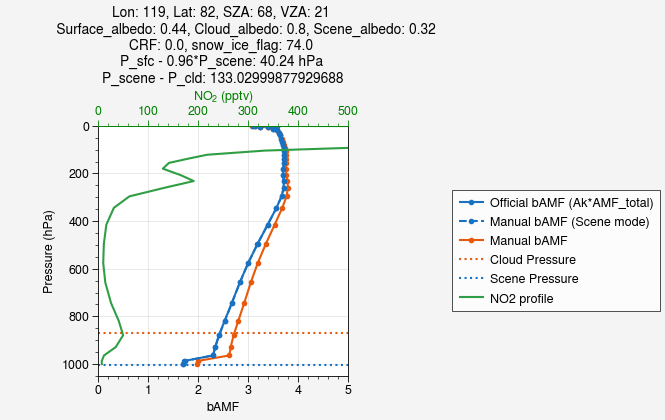

In [8]:
comp_amf(s5p_201908, scanline=3420, ground_pixel=300, kind='clear')

My method can reproduce the official bAMFs.

For clear pixels, the surface pressure is larger than the scene pressure and using scene pressure can lead to underestimated AMF.

### Cloudy pixel

> The retrieved scene pressure is the radiance-weighted average of the cloud pressure and the surface pressure.
> 
> In a cloud-free scene, the scene pressure is usually close to surface pressure.
>
> In a fully cloudy scene with optically thick clouds, the scene pressure can be very similar to the cloud pressure.

Pick the pixel of high NO2 caused by lightning to check the bAMF profile:

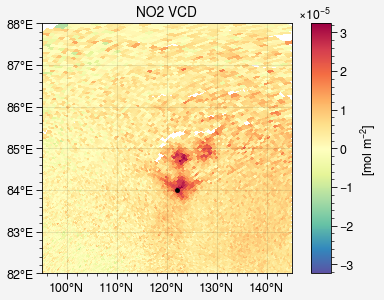

In [9]:
lon_min = 95; lon_max = 145
lat_min = 82; lat_max = 88

lon = s5p_201908['longitude']
lat = s5p_201908['latitude']

mask = (lon>lon_min) & (lon<lon_max) & (lat>lat_min) & (lat<lat_max)

s5p_201908_subset = s5p_201908.where(mask, drop=True).where(mask, drop=True)#.sel(scanline=slice(3400, 3440), ground_pixel = slice(310,350))


fig, axs = pplt.subplots()

s5p_201908_subset['nitrogendioxide_tropospheric_column'].plot(ax=axs[0], x='longitude', y='latitude', cmap='Spectral_r', discrete=False, cbar_kwargs={'label': '[mol m$^{-2}$]'})

# plot the location of the picked pixel
axs.scatter(s5p_201908['longitude'].sel(scanline=3435, ground_pixel=335),
            s5p_201908['latitude'].sel(scanline=3435, ground_pixel=335),
            c='k', s=8)

axs.format(title='NO2 VCD',
           xlim=(lon_min,lon_max), ylim=(lat_min,lat_max),
           xformatter='deglat', yformatter='deglon',
           xlabel='', ylabel='', grid=True,
           )

CRF:  0.9352415800094604


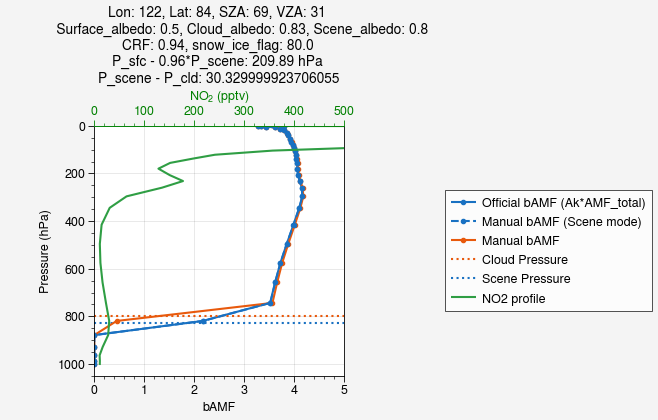

In [10]:
comp_amf(s5p_201908, scanline=3435, ground_pixel=335, kind='cloudy')

Compare the FRESCO and O2-O2 cloud products:

CRF:  0.9993140697479248


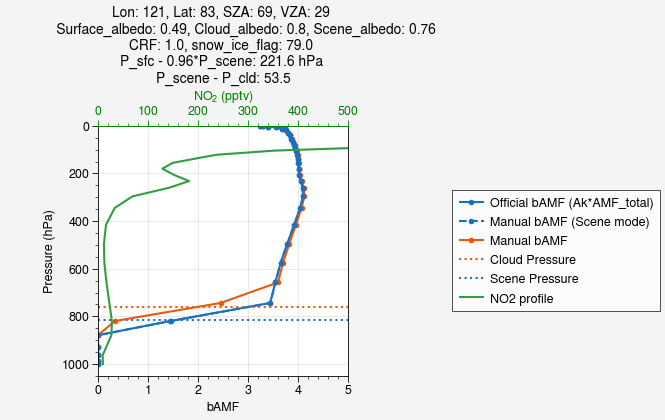

In [11]:
comp_amf(s5p_201908, scanline=3432, ground_pixel=329, kind='cloudy')
# comp_amf(s5p_201908, scanline=3435, ground_pixel=335, kind='cloudy')

CRF:  0.9993140697479248


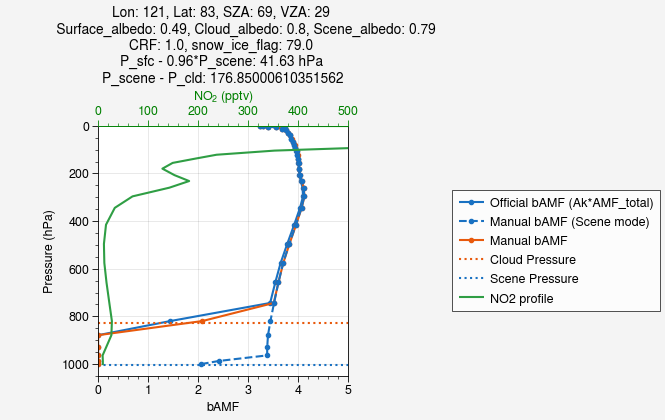

In [12]:
comp_amf(s5p_201908, scanline=3432, ground_pixel=329, kind='cloudy', cloud_product='o2-o2')
# comp_amf(s5p_201908, scanline=3435, ground_pixel=335, kind='cloudy', cloud_product='o2-o2')

The cloud pressure is similar with the scene pressure.
The difference is ~ 50 hPa (scene pressure level is lower).

Interestingly, the FRESCO scene pressure is close to the O2-O2 cloud pressure.

Let's check the geo distribution of different kinds of pressure.

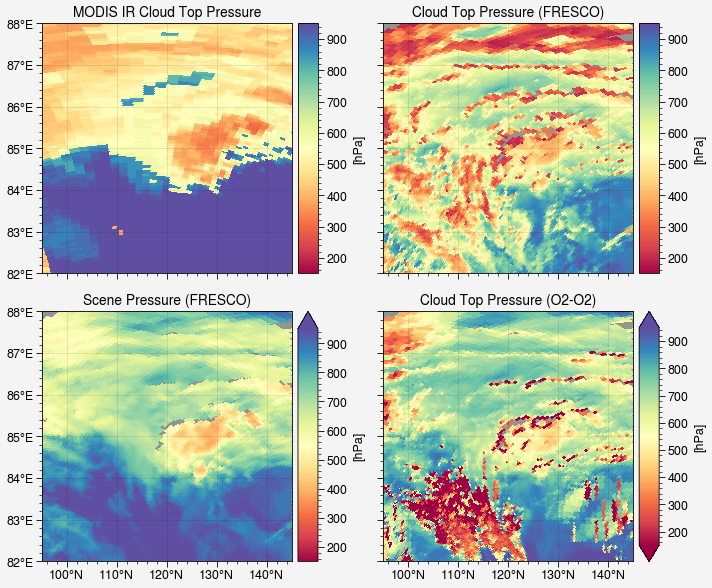

In [13]:
fig, axs = pplt.subplots(nrows=2, ncols=2)

ax = axs[0]
m = ax.pcolormesh(lon_modis, lat_modis,
               scn_modis['cloud_top_pressure_infrared'], cmap='Spectral', discrete=False, vmin=150, vmax=950)
ax.colorbar(m, loc='r', label='[hPa]')

s5p_201908_subset['cloud_pressure_crb'].plot(ax=axs[1], x='longitude', y='latitude', cmap='Spectral', discrete=False, vmin=150, vmax=950, cbar_kwargs={'label': '[hPa]'})
s5p_201908_subset['apparent_scene_pressure'].plot(ax=axs[2], x='longitude', y='latitude', cmap='Spectral', discrete=False, vmin=150, vmax=950, cbar_kwargs={'label': '[hPa]'})
s5p_201908_subset['o22cld_cloud_pressure_crb'].plot(ax=axs[3], x='longitude', y='latitude', cmap='Spectral', discrete=False, vmin=150, vmax=950, cbar_kwargs={'label': '[hPa]'})

# # plot the location of the picked pixel
# axs.scatter(s5p_201908['longitude'].sel(scanline=3432, ground_pixel=329),
#             s5p_201908['latitude'].sel(scanline=3432, ground_pixel=329),
#             c='k', s=8)

axs.format(title=['MODIS IR Cloud Top Pressure', 'Cloud Top Pressure (FRESCO)',
                  'Scene Pressure (FRESCO)', 'Cloud Top Pressure (O2-O2)'],
           xlim=(lon_min,lon_max), ylim=(lat_min,lat_max),
           xformatter='deglat', yformatter='deglon',
           xlabel='', ylabel='', grid=True, facecolor='gray',
           )

According to Fig. 12 of Vasilkov et al. (2008), the optical cloud top (rust
triangles) is lower than the IR cloud top (red squares).

![Cloud_pressures](https://agupubs.onlinelibrary.wiley.com/cms/asset/972743a7-5057-4a6a-865b-cc5ff7903703/jgrd13952-fig-0012.png)

So, using the scene pressure when snow/ice flag > 5 is reasonable!

**Users should be careful of the cloud pressure over snow/ice pixels**. There're many overestimated cloud pressures as shown in the figure above!

## CRF = 1 over snow/ice pixels

How about the clour radiance fraction (CRF)? The scene mode sets all snow/ice pixels to CRF=1.

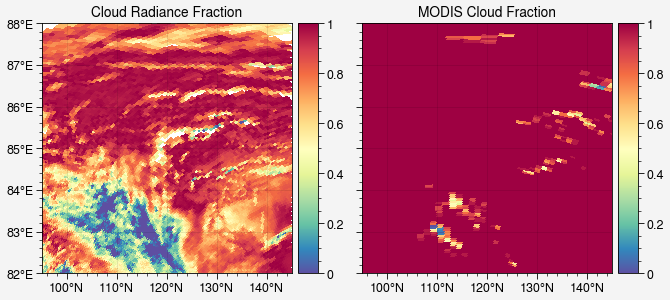

In [14]:
fig, axs = pplt.subplots(ncols=2)

ax = axs[0]

s5p_201908_subset['cloud_radiance_fraction_nitrogendioxide_window'].plot(ax=axs[0], x='longitude', y='latitude', cmap='Spectral_r', discrete=False, vmin=0, vmax=1, cbar_kwargs={'label': ''})

ax = axs[1]
m = ax.pcolormesh(lon_modis, lat_modis,
               scn_modis['cloud_fraction'], cmap='Spectral_r', discrete=False, vmin=0, vmax=1)
ax.colorbar(m, loc='r', label='')
ax.format(title='MODIS Cloud Fraction')

axs.format(title=['Cloud Radiance Fraction', 'MODIS Cloud Fraction'],
           xlim=(lon_min,lon_max), ylim=(lat_min,lat_max),
           xformatter='deglat', yformatter='deglon',
           xlabel='', ylabel='', grid=True,
           )

1) For pixels where convection occurs, the CRFs are usually > 0.9. So, assuming CRF=1 is fine.

2) For clear pixels, using scene pressure and CRF=1 stands for the snow near the ground.

3) The possible issues should exist for part-cloudy pixels. Fortunately, most of the lightning NO2 stays inside the thick cloud.